In [ ]:
# Callin Switzer
# 16 July 2019
# python infrared reader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import serial
import re
import csv
import seaborn as sns
import warnings
import sys
import os
from datetime import datetime
import msvcrt
import winsound

In [2]:
%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# data for storing datafile
dataDir = r"C:\Users\cswitzer.BEES\Desktop\MonarchSensor"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"C:\Users\cswitzer.BEES\Desktop\MonarchFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
C:\Anaconda3\envs\photogate\python.exe


In [3]:
def serial_ports():
    """ Lists serial port names
        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

# list serial ports
serial_ports() # this arduino is on COM6

['COM1', 'COM3', 'COM4', 'COM6']

In [4]:
# connect to arduino
PORT1 = "COM6"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1, 19200, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))  # read some example data   

connected to arduino on COM6


'189,97,116,158,184,172\n'

In [5]:
# def stream data
# refref not working


def plot_stream_data(dat, ctr):
    
    #plt.gca().cla() # optionally clear axes

    plt.plot(ctr, dat, 'o', c = 'C0')
    #plt.xlim([0, 1])
    plt.title(str(ctr))
    plt.draw()
    #plt.pause(0.0001)

    #plt.show(block=True)

In [6]:
ctr = 0
maxTime = 6 # minutes


while msvcrt.kbhit():
    msvcrt.getch()
    print('clearing characters ...')


while True:
    
    if msvcrt.kbhit(): # if q, or escape is pressed, then break the loop
        k = msvcrt.getch()
        if(k == b'q') | (k == b'\x1b') | (k == b'\x0b') :
            print("keyboard break")
            winsound.MessageBeep()
            break
            

    if ctr == 0:
        
        minuteCounter = 0
       
        # discard first read line, in case it's the wrong length
        ser1.readline()
        
        txt = ser1.readline().decode("utf-8")
        colNames = ["A" + str(i) for i, _ in enumerate(txt.split(','))]
        colNames.append("datetime")
        
        # make file  and write header
        fileStart = datetime.now()
        fname = (fileStart.strftime('%Y-%m-%d %H:%M:%S.%f'))
        fname = re.sub(r'[^\w\s]','_',fname)
        fname = re.sub(" ", "__", fname)[0:] + ".csv"

        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([colNames])
    
    
    # read data
    # ser1.readline() # discard first readline
    txt = ser1.readline().decode("utf-8")
    
    serData = [int(i) for i in txt.split(',') if i != ""]
    readTime = datetime.now()
    serData.append(readTime.strftime('%Y-%m-%d %H:%M:%S.%f'))

    # write data, but only if it's not an incorrect reading
    if (len(serData) != len(colNames)):
        print("data length is different from length of columns, dropping a reading")
        continue
        
    elif (np.max(serData[:-1]) > 1023):
        print("data range incorrect, dropping a reading")
        continue
    
    else:
        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([serData])

    # print time
    c = readTime - fileStart
    if c.total_seconds()//60 == minuteCounter:
        print("Time elapsed (minutes):", minuteCounter)
        minuteCounter += 5 # print every 5 minutes
    
    if divmod(c.days * 86400 + c.seconds, 60)[0] >= maxTime:
        break   
    
    # update ctr
    ctr += 1
#     ser1.flushInput()

print('done')

Time elapsed (minutes): 0
keyboard break
done


In [7]:
c.total_seconds()/60

0.18505723333333332

In [8]:
# look at data
# read in data
dfile = os.path.join(dataDir,fname)
df1 = pd.read_csv(dfile)
#df1 = df1.iloc[1500:2000,:].copy()
df1['datetime']= pd.to_datetime(df1['datetime'])
print(df1.shape)
df1.tail()

(1104, 7)


,A0,A1,A2,A3,A4,A5,datetime
1099,189,98,116,119,127,124,2019-08-23 08:41:54.099278
1100,189,97,117,119,129,126,2019-08-23 08:41:54.111508
1101,189,98,119,117,122,121,2019-08-23 08:41:54.119578
1102,189,98,116,118,122,119,2019-08-23 08:41:54.132043
1103,190,97,117,120,130,127,2019-08-23 08:41:54.144324


C:\Anaconda3\envs\photogate\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


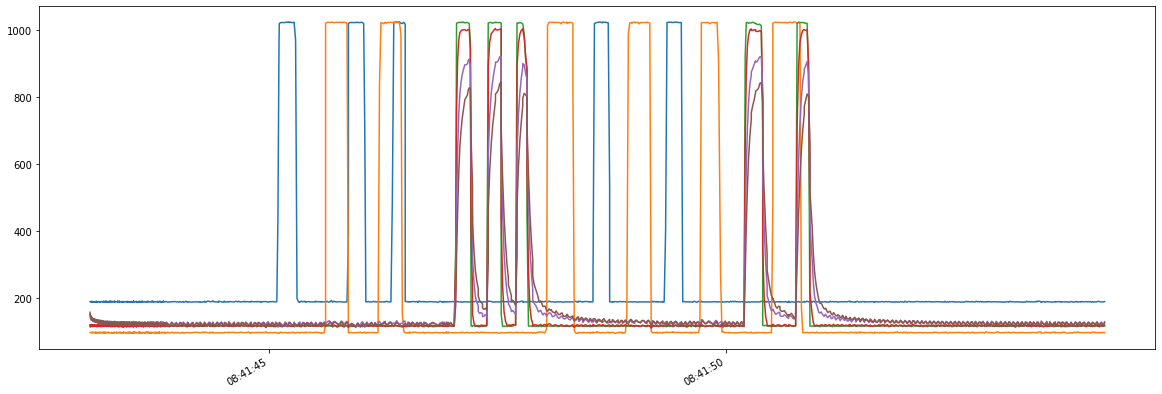

In [9]:
fig, ax = plt.subplots(1,1, figsize = [20,7])
for ii in range(6):
    ax.plot(df1.datetime, df1.iloc[:,ii])
fig.autofmt_xdate()
plt.show()


In [ ]:
fname